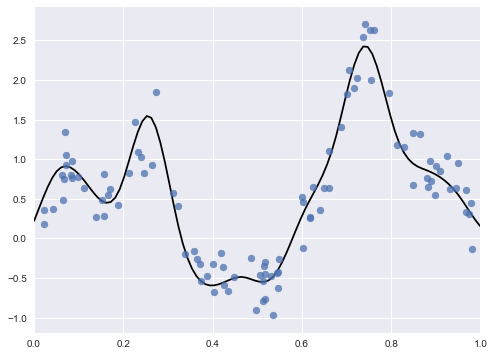

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.76it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



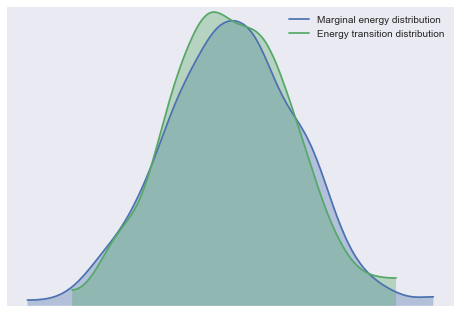

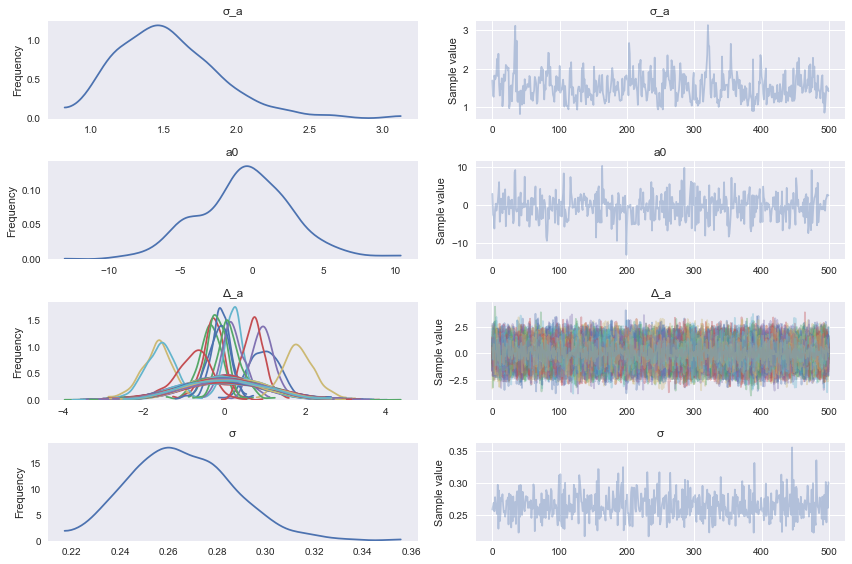

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1848.97it/s]


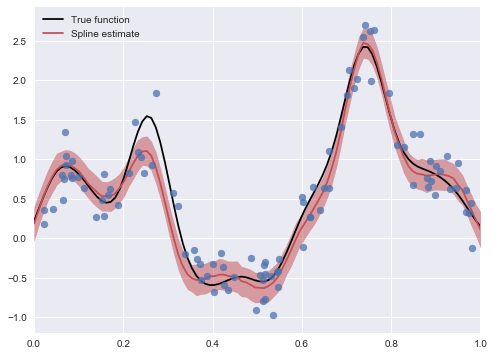

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import shared

blue, green, red, purple, gold, teal = sns.color_palette()

N_KNOT = 30
knots = np.linspace(-0.5, 1.5, N_KNOT)
c = np.random.normal(size=N_KNOT)
# t:knots, c:spline coefficients  k:B-spline order extrapolate:bool or periodic,optional
spline = sp.interpolate.BSpline(knots, c, 3, extrapolate=False)

x = np.random.uniform(0, 1, 100)
x.sort()
y = spline(x) + np.random.normal(scale=0.25, size=x.size)

x_plot = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, spline(x_plot), c='k')
ax.scatter(x, y, alpha=0.75, zorder=5)
ax.set_xlim(0, 1)
plt.show()

# 正式建模
N_MODEL_KNOTS = 5 * N_KNOT
model_knots = np.linspace(-0.5, 1.5, N_MODEL_KNOTS)
# np.eye：生成单元对角矩阵，Return a 2-D array with ones on the diagonal and zeros elsewhere
basis_funcs = sp.interpolate.BSpline(knots, np.eye(N_MODEL_KNOTS), k=3)
Bx = basis_funcs(x) # 表示在取值为x时的插值函数值
# shared:符号变量（symbolic variable），a之所以叫shared variable是因为a的赋值在不同的函数中都是一致的搜索，即a是被shared的
Bx_ = shared(Bx)

with pm.Model() as model:
    σ_a = pm.HalfCauchy('σ_a', 5.)
    a0 = pm.Normal('a0', 0., 10.)
    Δ_a = pm.Normal('Δ_a', 0., 1., shape=N_MODEL_KNOTS)

    a = pm.Deterministic('a', a0 + (σ_a * Δ_a).cumsum())  # cumsum:返回累积和
    σ = pm.HalfCauchy('σ', 5.)

    obs = pm.Normal('obs', Bx_.dot(a), σ, observed=y)

Bx_.set_value(basis_funcs(x_plot))

with model:
    trace = pm.sample(nuts_kwargs={'target_accept': 0.95})

pm.energyplot(trace)
plt.show()

varnames1 = ['σ_a', 'a0', 'Δ_a', 'σ']
pm.traceplot(trace, varnames1)
plt.show()

# 后验分析
with model:
    pp_trace = pm.sample_ppc(trace, 1000)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_plot, spline(x_plot), c='k', label="True function")

low, high = np.percentile(pp_trace['obs'], [25, 75], axis=0)
ax.fill_between(x_plot, low, high, color=red, alpha=0.5)
ax.plot(x_plot, pp_trace['obs'].mean(axis=0), c=red, label="Spline estimate")

ax.scatter(x, y, alpha=0.75, zorder=5)
ax.set_xlim(0, 1)
ax.legend()
plt.show()




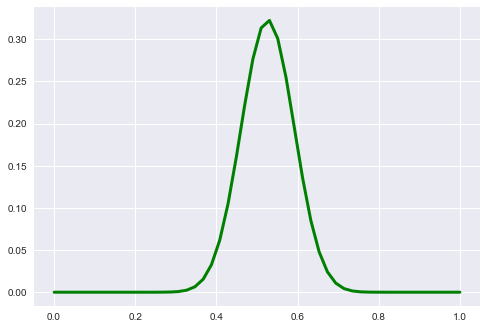

In [2]:
xx = np.linspace(0, 1, 20)
b = sp.interpolate.BSpline.basis_element(xx[1:])
print(b)
fig, ax = plt.subplots()
x = np.linspace(0, 1, 50)
ax.plot(x, b(x), 'g', lw=3)
ax.grid(True)
plt.show()